## San Francisco Crime Classification EDA

- Kaggle 주소: [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime)
- 경진대회의 목표: 특정 위치 데이터를 활용해서 특정 시간대, 요일, 관할서에서 일어난 범죄를 분석해서 범죄의 구체적인 종류를 예측하는 것

In [1]:
import pandas as pd
import numpy as np

## Load Dataset

In [2]:
train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


### 데이터 설명
- row의 사이즈가 매우 큰 데이터, 실전 데이터 분석에 도움이 될 듯
- column의 설명
    - **Datas**: 범죄가 발생한 날짜와 시간 
    - **Category**: 범죄의 세부종류(label colum)
    - Descript: 범죄의 세부정보(test.csv에는 없는 데이터, 참고용으로만 사용되는 데이터)
    - **DayOfWeek**: 범죄가 발생한 요일(월~일)
    - **PdDistrict**: 범죄 관할 경찰서 이름(총 10개)
    - Resolution: 범죄의 상태, 범죄 해결 여부(test.csv에는 없는 데이터, 참고용으로만 사용되는 데이터)
    - **Address**: 범죄가 발생한 구체적인 주소(미국의 주소체계, 샌프란시스코 주소체계에 대한 도메인 지식이 있다면 좋은 예측 모델을 나타낼 수 있음)
    - **X**: 범죄가 발생한 좌표 정보(경도)
    - **Y**: 범죄가 발생한 좌표 정보(위도)

## Explore
- 탐험적 데이터 분석(Exploratory Data Analysis, EDA)이 중요
    - 파이썬 패키지는 자유롭게 선택가능
    - 데이터 시각화: matplotlib, seaborn, ggplot, bokeh 등 사용 가능
- Cross Validation을 활용해 머신러닝 모델의 성능을 측정, 점수로 피드백 받아 모델 개선(Try and Error 방식으로 모델을 점진적으로 개선함)
    - 단, 모델이 개선되거나 개선되지 않았을때 이유를 명확히 파악하기 어려움
    - 모델 개선의 구체적 전략을 짜는 것이 어려움

### Library loading

In [4]:
# matplotlib으로 시각화하는 것을 jupyter notebook에 바로 띄움
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

### Dates Column
- Dates 형식
    - dtype('O'): 문자열, object
    - to_datetime()으로 변환

In [5]:
train["Dates"].dtypes

dtype('O')

In [6]:
# 문자열(string, object) 데이터 타입을 DateTime 형태로 변환
pd.to_datetime(train["Dates"]).dtypes

dtype('<M8[ns]')

In [7]:
train["Dates"] = pd.to_datetime(train["Dates"])
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

In [8]:
# pandas에 Dates 컬럼을 년,월,일,시,분,초 새로운 컬럼으로 따로 추가
train["Dates-year"] = train["Dates"].dt.year
train["Dates-month"] = train["Dates"].dt.month
train["Dates-day"] = train["Dates"].dt.day
train["Dates-hour"] = train["Dates"].dt.hour
train["Dates-minute"] = train["Dates"].dt.minute
train["Dates-second"] = train["Dates"].dt.second

print(train.shape)
train[["Dates", "Dates-year", "Dates-month", "Dates-day", "Dates-hour", "Dates-minute", "Dates-second"]].head()

(878049, 15)


,Dates,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
0,2015-05-13 23:53:00,2015,5,13,23,53,0
1,2015-05-13 23:53:00,2015,5,13,23,53,0
2,2015-05-13 23:33:00,2015,5,13,23,33,0
3,2015-05-13 23:30:00,2015,5,13,23,30,0
4,2015-05-13 23:30:00,2015,5,13,23,30,0


**시각화**
- 시각화 전 시각화의 예상 결과를 미리 상상하는 것을 추천
- seaborn의 [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)을 이용하여 시각화

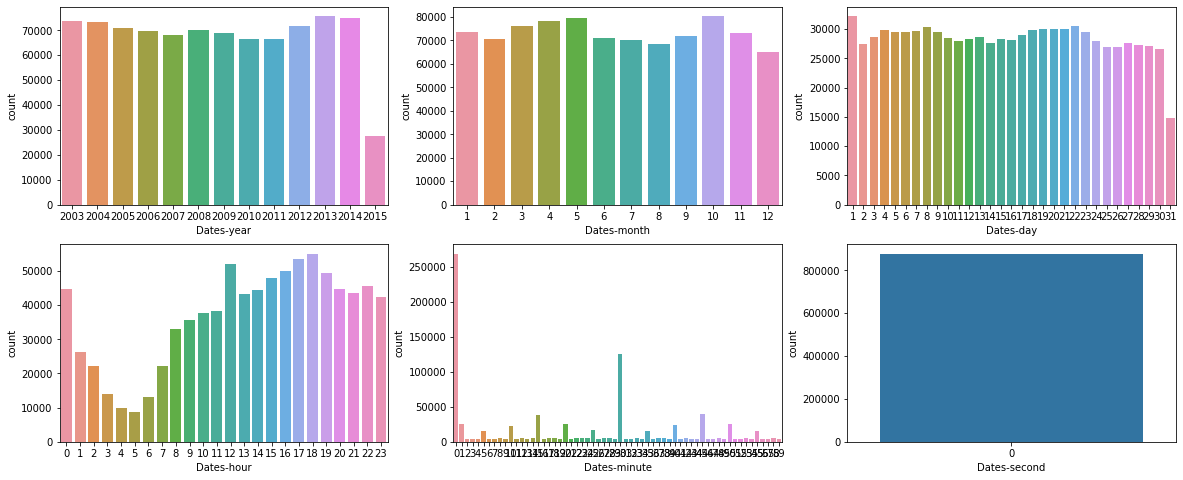

In [9]:
# 여러개의 시각화를 한 화면에 띄움: matplotlib의 subplots 사용
# 2*3으로 총 6개의 시각화를 한 화면에 띄움
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)

# 시각화 전체 사이즈 지정
figure.set_size_inches(20, 8)

sns.countplot(data=train, x="Dates-year", ax=ax1) # ax1: 좌상단
sns.countplot(data=train, x="Dates-month", ax=ax2)
sns.countplot(data=train, x="Dates-day", ax=ax3)
sns.countplot(data=train, x="Dates-hour", ax=ax4)
sns.countplot(data=train, x="Dates-minute", ax=ax5)
sns.countplot(data=train, x="Dates-second", ax=ax6) # ax6: 우하단

- year: 2015년만 범죄 발생수가 작음
- month: 균등
- day: 1일은 많고 31일은 범죄 발생수가 적음(31일이 적은 이유는 1,3,5,7,8,10,12월만 존재하기 때문에)
- hour: 새벽에는 범죄 발생수가 적음
- minute: 0, 30분에 범죄발생수가 많음(0,30,45,15,20분 순으로 많음)
- second: 모두 0으로 범죄 발생에 영향 없음

```feadback```
1. 초(Dates-second), 분(Dates-minute)는 정확하게 기록되어 있지 않을 가능성이 높다.
2. 초(Dates-second)는 전부 0으로 기록되어 있기 때문에 범죄를 예측하는데 크게 중요하지 않은 것 같음, feature를 제거하는 것도 좋은 아이디어다.
3. 시간(Dates-hour)은 범죄를 예측하는 데 큰 영향을 미칠 것으로 보인다.
4. 분(Dates-minute)은 잘 정리하면 머신러닝 모델이 이 데이터를 이용하는데 도움이 될 것 같다.
    - 0분, 30분은 배제하고 나머지 분들을 사용

In [10]:
train["Dates-minute"].value_counts().head()

0     268950
30    125173
45     40229
15     37904
20     26027
Name: Dates-minute, dtype: int64

In [11]:
train["Dates-hour"].value_counts().tail(10)

10    37806
9     35555
8     32900
1     26173
2     22296
7     22048
3     14014
6     13133
4      9863
5      8637
Name: Dates-hour, dtype: int64

### X, Y Column
- X: 경도, Y: 위도
- seaborn의 [lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html)을 이용해 좌표정보를 시각화

In [12]:
train[["X", "Y"]]

,X,Y
0,-122.425892,37.774599
1,-122.425892,37.774599
2,-122.424363,37.800414
3,-122.426995,37.800873
4,-122.438738,37.771541
...,...,...
878044,-122.459033,37.714056
878045,-122.447364,37.731948
878046,-122.403390,37.780266
878047,-122.390531,37.780607


**시각화**

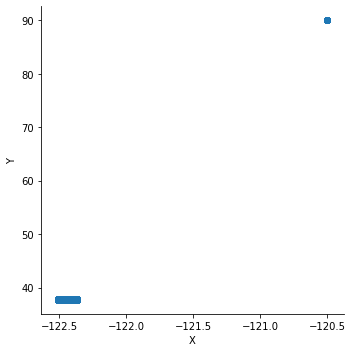

In [13]:
# seaborn의 lmplot을 사용해 좌표 데이터를 출력
# fil_reg 옵션에 False 지정 (추세선을 그리지 않기 위해 지정, 계산속도 느림)
sns.lmplot(data=train, x="X", y="Y", fit_reg=False)

In [14]:
train["X"].max(), train["Y"].max()

(-120.5, 90.0)

In [15]:
# outlier 데이터를 가져옴
X_outliers = train["X"] == train["X"].max()
Y_outliers = train["Y"] == train["Y"].max()

outlier = train[X_outliers & Y_outliers]
print(outlier.shape)
outlier.head()

(67, 15)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005,12,30,17,0,0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,34,0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,34,0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0,2005,12,29,0,7,0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0,2005,11,30,11,25,0


**아웃라이어를 제외하고 시각화**
- 샌프란시스코 지도 모양으로 시각화 됨

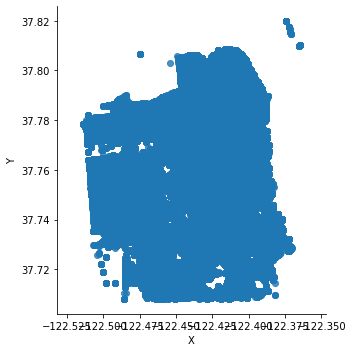

In [16]:
# outlier가 아닌(~) 데이터만 색인으로 추출
non_outliers = train[~(X_outliers & Y_outliers)]

# 시각화
sns.lmplot(data=non_outliers, x="X", y="Y", fit_reg=False)

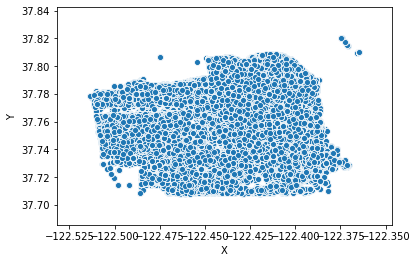

In [17]:
sns.scatterplot(x="X", y="Y", data=non_outliers)

```feadback```
1. 아웃라이어가 전체 데이터에 0.01%도 되지 않기 때문에 이 아웃라이어를 해결한다고 모델의 성능이 크게 좋아지지는 않는다.
2. 범죄의 종류마다 좌표데이터가 차이가 있다면(특정 지역에서 많이 발생하는 범죄 등이 있다면) 이 데이터를 머신러닝 모델에 집어넣으면 성능을 좋게 만들수 있을 것이다.
3. 아웃라이어가 존재한다면, 이를 정상적인 값으로 고치거나 아예 아웃라이어를 배제하면 머신러닝 알고리즘이 아웃라이어에 편향되는 현상이 사라질 것이다.

### DayOfWeek Column

In [18]:
non_outliers["DayOfWeek"].value_counts()

Friday       133723
Wednesday    129200
Saturday     126804
Thursday     125027
Tuesday      124954
Monday       121573
Sunday       116701
Name: DayOfWeek, dtype: int64

**시각화**
- 요일마다 범죄 발생률의 차이가 크지 않으나 금요일(Friday)이 비교적 높고 일요일(Sunday)이 비교적 낮다.

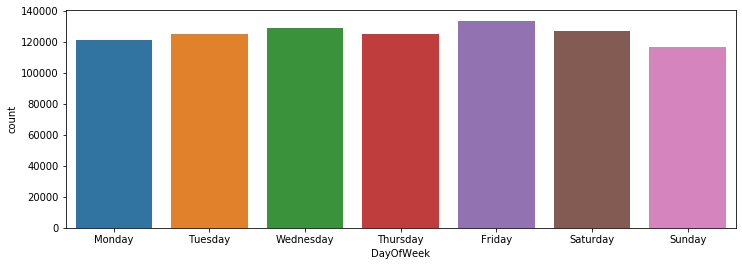

In [19]:
plt.figure(figsize=(12,4))
# seaborn의 경우 자동정렬이 되지 않으므로, 명시적으로 정렬 순서를 정해줌
dwofweek_list = ["Monday", "Tuesday", "Wednesday", 
                 "Thursday", "Friday", "Saturday", "Sunday"]

sns.countplot(x="DayOfWeek", order=dwofweek_list, data=non_outliers)

### Category Column
- LARCENY/THEFT: 절도(경범죄)
- OTHER OFFENSES: 기타
- NON-CRIMINAL: 범죄가 아님?
- ASSAULT: 폭행
- DRUG/NARCOTIC: 마약
- VEHICLE THEFT: 차량 절도
- VANDALISM: 기물 파손
- WARRANTS: 구속
- BURGLARY: 절도(중범죄)
- SUSPICIOUS OCC: 의심스러운 행위
- MISSING PERSON: 실종
- ROBBERY: 강도
- FRAUD: 사기
- FORGERY/COUNTERFEITING: 위조
- SECONDARY CODES: 2차적 배경들이 있는 범죄
- WEAPON LAWS: 총기 사고
- PROSTITUTION: 매춘
- TRESPASS: 무단 침입
- STOLEN PROPERTY: 도난
- SEX OFFENSES FORCIBLE: 강제적 성범죄
- DISORDERLY CONDUCT: 문란 행위
- DRUNKENNESS: 과음
- RECOVERED VEHICLE: 차량 탈취
- KIDNAPPING: 납치, 유괴
- DRIVING UNDER THE INFLUENCE: 음주 운전
- RUNAWAY: 가출
- LIQUOR LAWS: 음주 및 기타 주류 유통 위반
- ARSON: 방화
- LOITERING: 의심스러운 배회 및 방황
- EMBEZZLEMENT: 횡령
- SUICIDE: 자살
- FAMILY OFFENSES: 가정 범죄
- BAD CHECKS: 부도 수표
- BRIBERY: 뇌물 수수
- EXTORTION: 갈취
- SEX OFFENSES NON FORCIBLE: 비강제적 성범죄
- GAMBLING: 도박
- PORNOGRAPHY/OBSCENE MAT: 음란행위, 외설행위
- TREA: 무단 침입

In [20]:
non_outliers["Category"].value_counts().index

Index(['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT',
       'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS', 'BURGLARY',
       'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY', 'FRAUD',
       'FORGERY/COUNTERFEITING', 'SECONDARY CODES', 'WEAPON LAWS',
       'PROSTITUTION', 'TRESPASS', 'STOLEN PROPERTY', 'SEX OFFENSES FORCIBLE',
       'DISORDERLY CONDUCT', 'DRUNKENNESS', 'RECOVERED VEHICLE', 'KIDNAPPING',
       'DRIVING UNDER THE INFLUENCE', 'RUNAWAY', 'LIQUOR LAWS', 'ARSON',
       'LOITERING', 'EMBEZZLEMENT', 'SUICIDE', 'FAMILY OFFENSES', 'BAD CHECKS',
       'BRIBERY', 'EXTORTION', 'SEX OFFENSES NON FORCIBLE', 'GAMBLING',
       'PORNOGRAPHY/OBSCENE MAT', 'TREA'],
      dtype='object')

In [21]:
non_outliers["Category"].value_counts()

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

**시각화**
- LARCENY/THEFT가 제일 많음

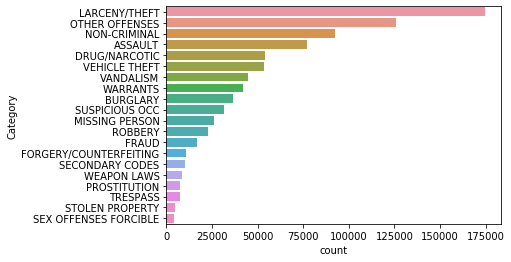

In [22]:
# 상위 20개 범죄 종류만 시각화
sns.countplot(y="Category", data=non_outliers, 
              order=non_outliers["Category"].value_counts().index[:20])

### DayOfWeek와 Category관계 확인
- DayOfWeek 시각화에서 큰 차이를 볼 수 없어서 Category 컬럼도 같이 시각화

#### 1. 첫번째 방법

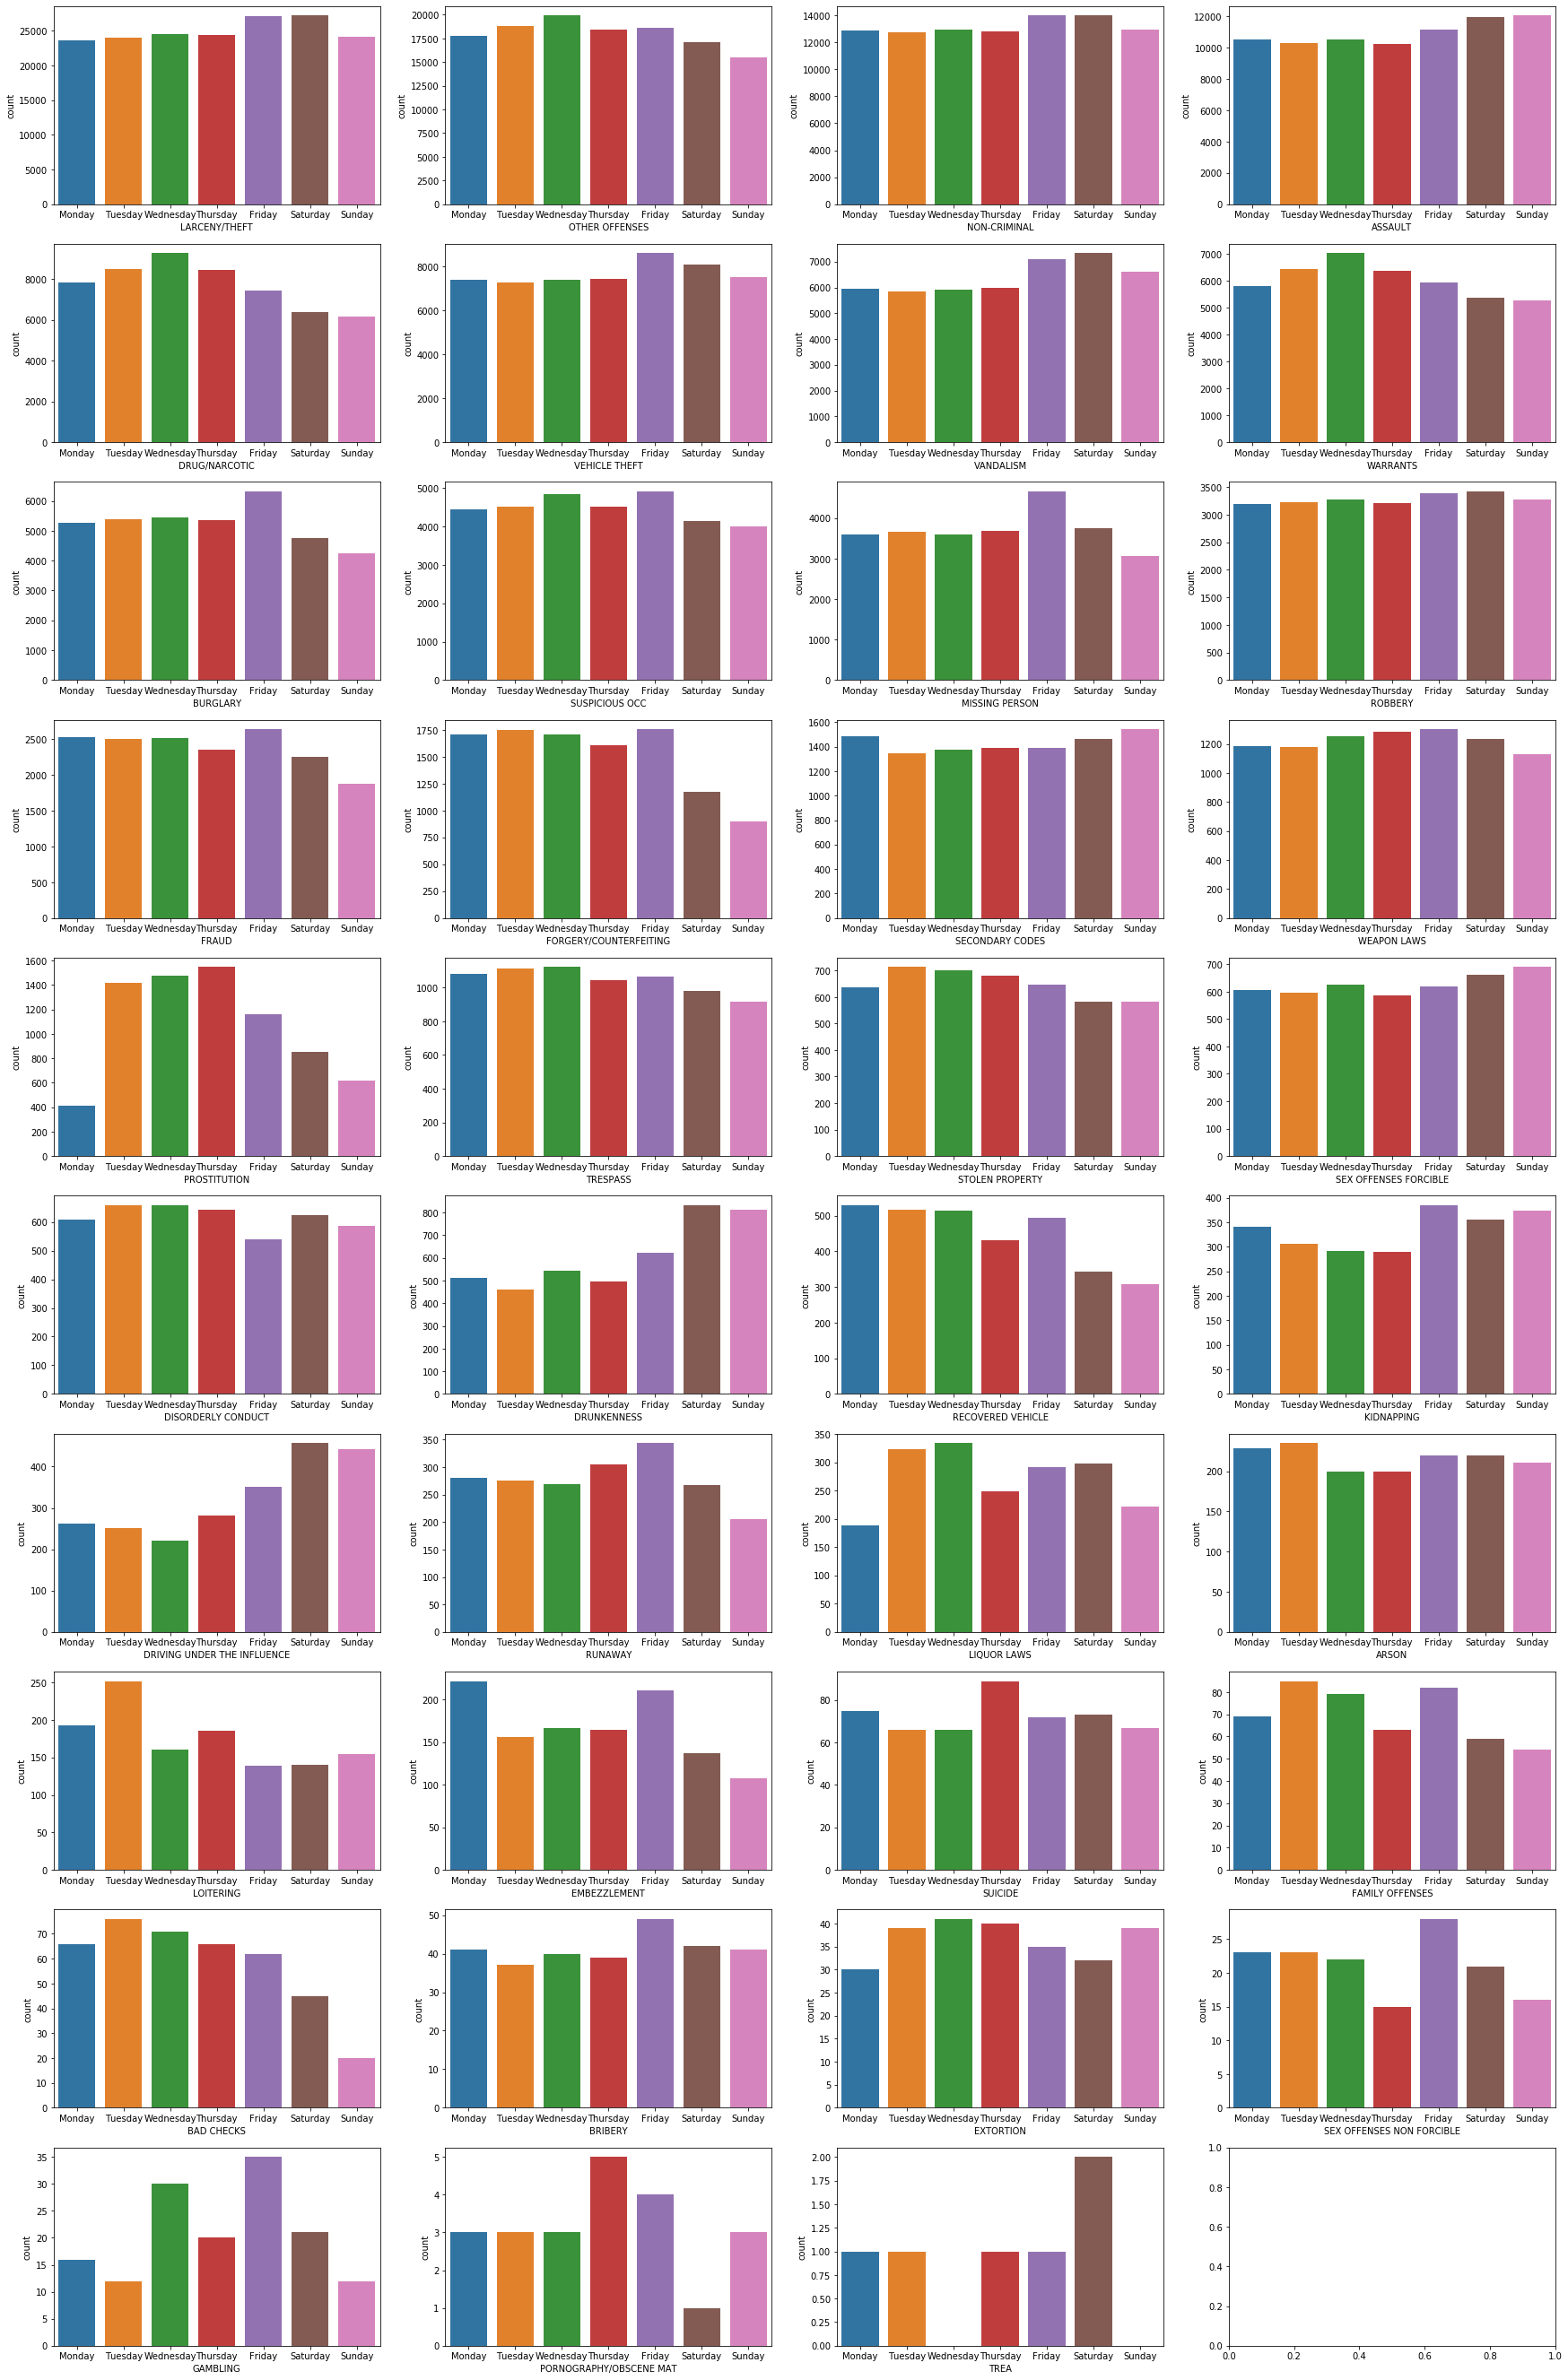

In [23]:
# 다수개의 차트를 같이 표현하는 방법
figure, axes = plt.subplots(nrows=10, ncols=4)

# 각 차트의 사이즈 지정
figure.set_size_inches(30, 48)

# seaborn의 경우 자동정렬이 되지 않으므로, 명시적으로 정렬 순서를 정해줌
dwofweek_list = ["Monday", "Tuesday", "Wednesday", 
                 "Thursday", "Friday", "Saturday", "Sunday"]

category_list = non_outliers["Category"].value_counts().index

# 반복문 수행
for row in range(10):
    for col in range(4):
        index = row * 4 + col #category의 개수가 39개
        
        if index < len(category_list):
            ax = axes[row][col]
            category = category_list[index]
            #print(row, col, index, category)
            
            target = non_outliers[non_outliers["Category"] == category]
            sns.countplot(x="DayOfWeek", order=dwofweek_list, data=target, ax=ax)
            ax.set(xlabel = category)

```feadback```
1. 몇몇 특정 범죄에 한해 주중이나 주말일때 범죄 발생에 차이가 있다.
   - 주말에 많이 발생: 특히 음주운전(DRIVING UNDER THE INFLUENCE), 과음(DRUNKENNESS), 무단침입(TREA)
   - 주중에 많이 발생: 마약(DRUG/NARCOTIC), 절도(BURGLARY), 위조(FORGERY/COUNTERFEITING)
2. 주말의 경우도 금,토 또는 토,일에 따라 범죄 발생률이 다르다.
3. 요일(DayOfWeek)가 범죄를 예측하는데 중요한 영향을 끼친다는 것을 알 수 있으므로 예측 모델의 성능을 개선하는데 효과가 있을것 같다.
4. 범죄마다 중요한 요일의 타입이 다르며, 대부분 주중과 주말로 나뉘며, 주말도 금,토 또는 토,일에 따라 다르다.
5. 예외적으로 특정 요일에만 발생하는 범죄가 있다.
   - 무단침입(TREA): 토요일
   - 실종(MISSING PERSON): 금요일

#### 2. 두번째 방법

In [24]:
groups = non_outliers.groupby(['Category', 'DayOfWeek'])['DayOfWeek'].count()
groups

Category     DayOfWeek
ARSON        Friday        220
             Monday        228
             Saturday      220
             Sunday        211
             Thursday      199
                          ... 
WEAPON LAWS  Saturday     1232
             Sunday       1128
             Thursday     1282
             Tuesday      1176
             Wednesday    1252
Name: DayOfWeek, Length: 271, dtype: int64

In [25]:
# Group으로 묶여진 데이터를 matrix형태로 전환
dw_category = groups.unstack(fill_value=0.0)
dw_category

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ARSON,220.0,228.0,220.0,211.0,199.0,235.0,200.0
ASSAULT,11157.0,10559.0,11995.0,12082.0,10246.0,10280.0,10553.0
BAD CHECKS,62.0,66.0,45.0,20.0,66.0,76.0,71.0
BRIBERY,49.0,41.0,42.0,41.0,39.0,37.0,40.0
BURGLARY,6326.0,5262.0,4754.0,4231.0,5350.0,5374.0,5457.0
DISORDERLY CONDUCT,541.0,608.0,624.0,586.0,643.0,657.0,659.0
DRIVING UNDER THE INFLUENCE,352.0,263.0,457.0,442.0,282.0,251.0,221.0
DRUG/NARCOTIC,7420.0,7823.0,6390.0,6143.0,8454.0,8474.0,9267.0
DRUNKENNESS,622.0,513.0,833.0,813.0,496.0,461.0,542.0


**시각화**

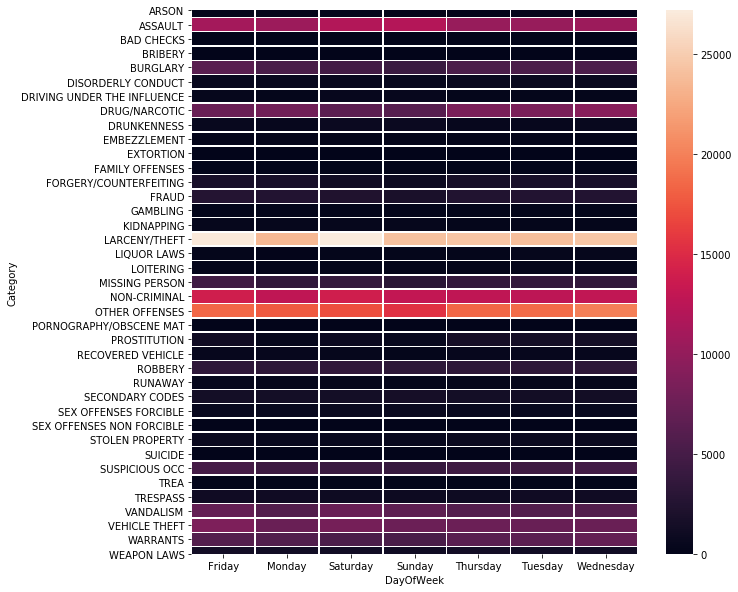

In [26]:
fg, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dw_category, linewidths=.5, ax=ax)

- 가장 많은 수의 범죄인 LARCENY/THREFT가 Saturday, Friday순으로 높음 

In [27]:
dw_category.loc['LARCENY/THEFT'].sort_values(ascending=False)

DayOfWeek
Saturday     27214.0
Friday       27102.0
Wednesday    24484.0
Thursday     24415.0
Sunday       24147.0
Tuesday      23955.0
Monday       23568.0
Name: LARCENY/THEFT, dtype: float64

### PdDistrict Column

In [28]:
non_outliers["PdDistrict"].unique()

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL',
       'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'], dtype=object)

In [29]:
non_outliers["PdDistrict"].value_counts()

SOUTHERN      157174
MISSION       119907
NORTHERN      105284
BAYVIEW        89422
CENTRAL        85455
TENDERLOIN     81794
INGLESIDE      78841
TARAVAL        65592
PARK           49311
RICHMOND       45202
Name: PdDistrict, dtype: int64

**시각화**
- 범죄의 관할서(PdDistrict)는 SOUTHERN, MISSION, MORTHERN순으로 높음

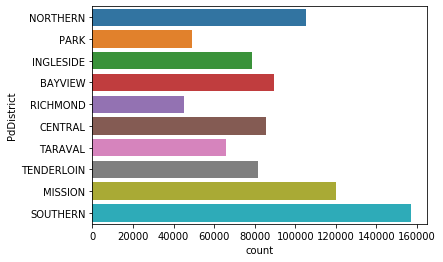

In [30]:
sns.countplot(data=non_outliers, y="PdDistrict")

- PdDistrict와 X, Y 좌표의 위치를 시각화
    - SOUTHERN, MISSION, MORTHERN의 위치가 몰려있음을 알 수 있음

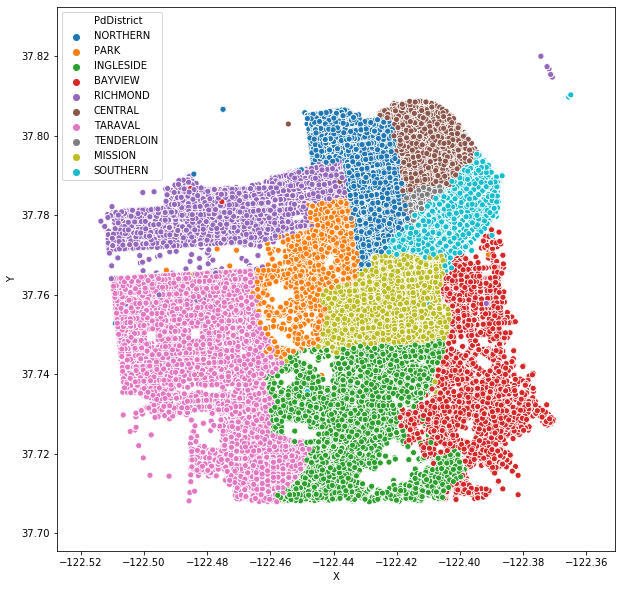

In [31]:
fg2, ax2 = plt.subplots(figsize=(10,10))
sns.scatterplot(x="X", y="Y", hue="PdDistrict", 
                data=non_outliers, ax=ax2)

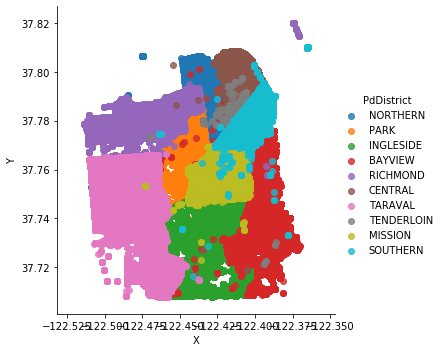

In [32]:
sns.lmplot(x="X", y="Y", hue="PdDistrict", 
           data=non_outliers, fit_reg=False)

### Category와 PdDistrict 관계 확인

#### 1. 첫번째 방법

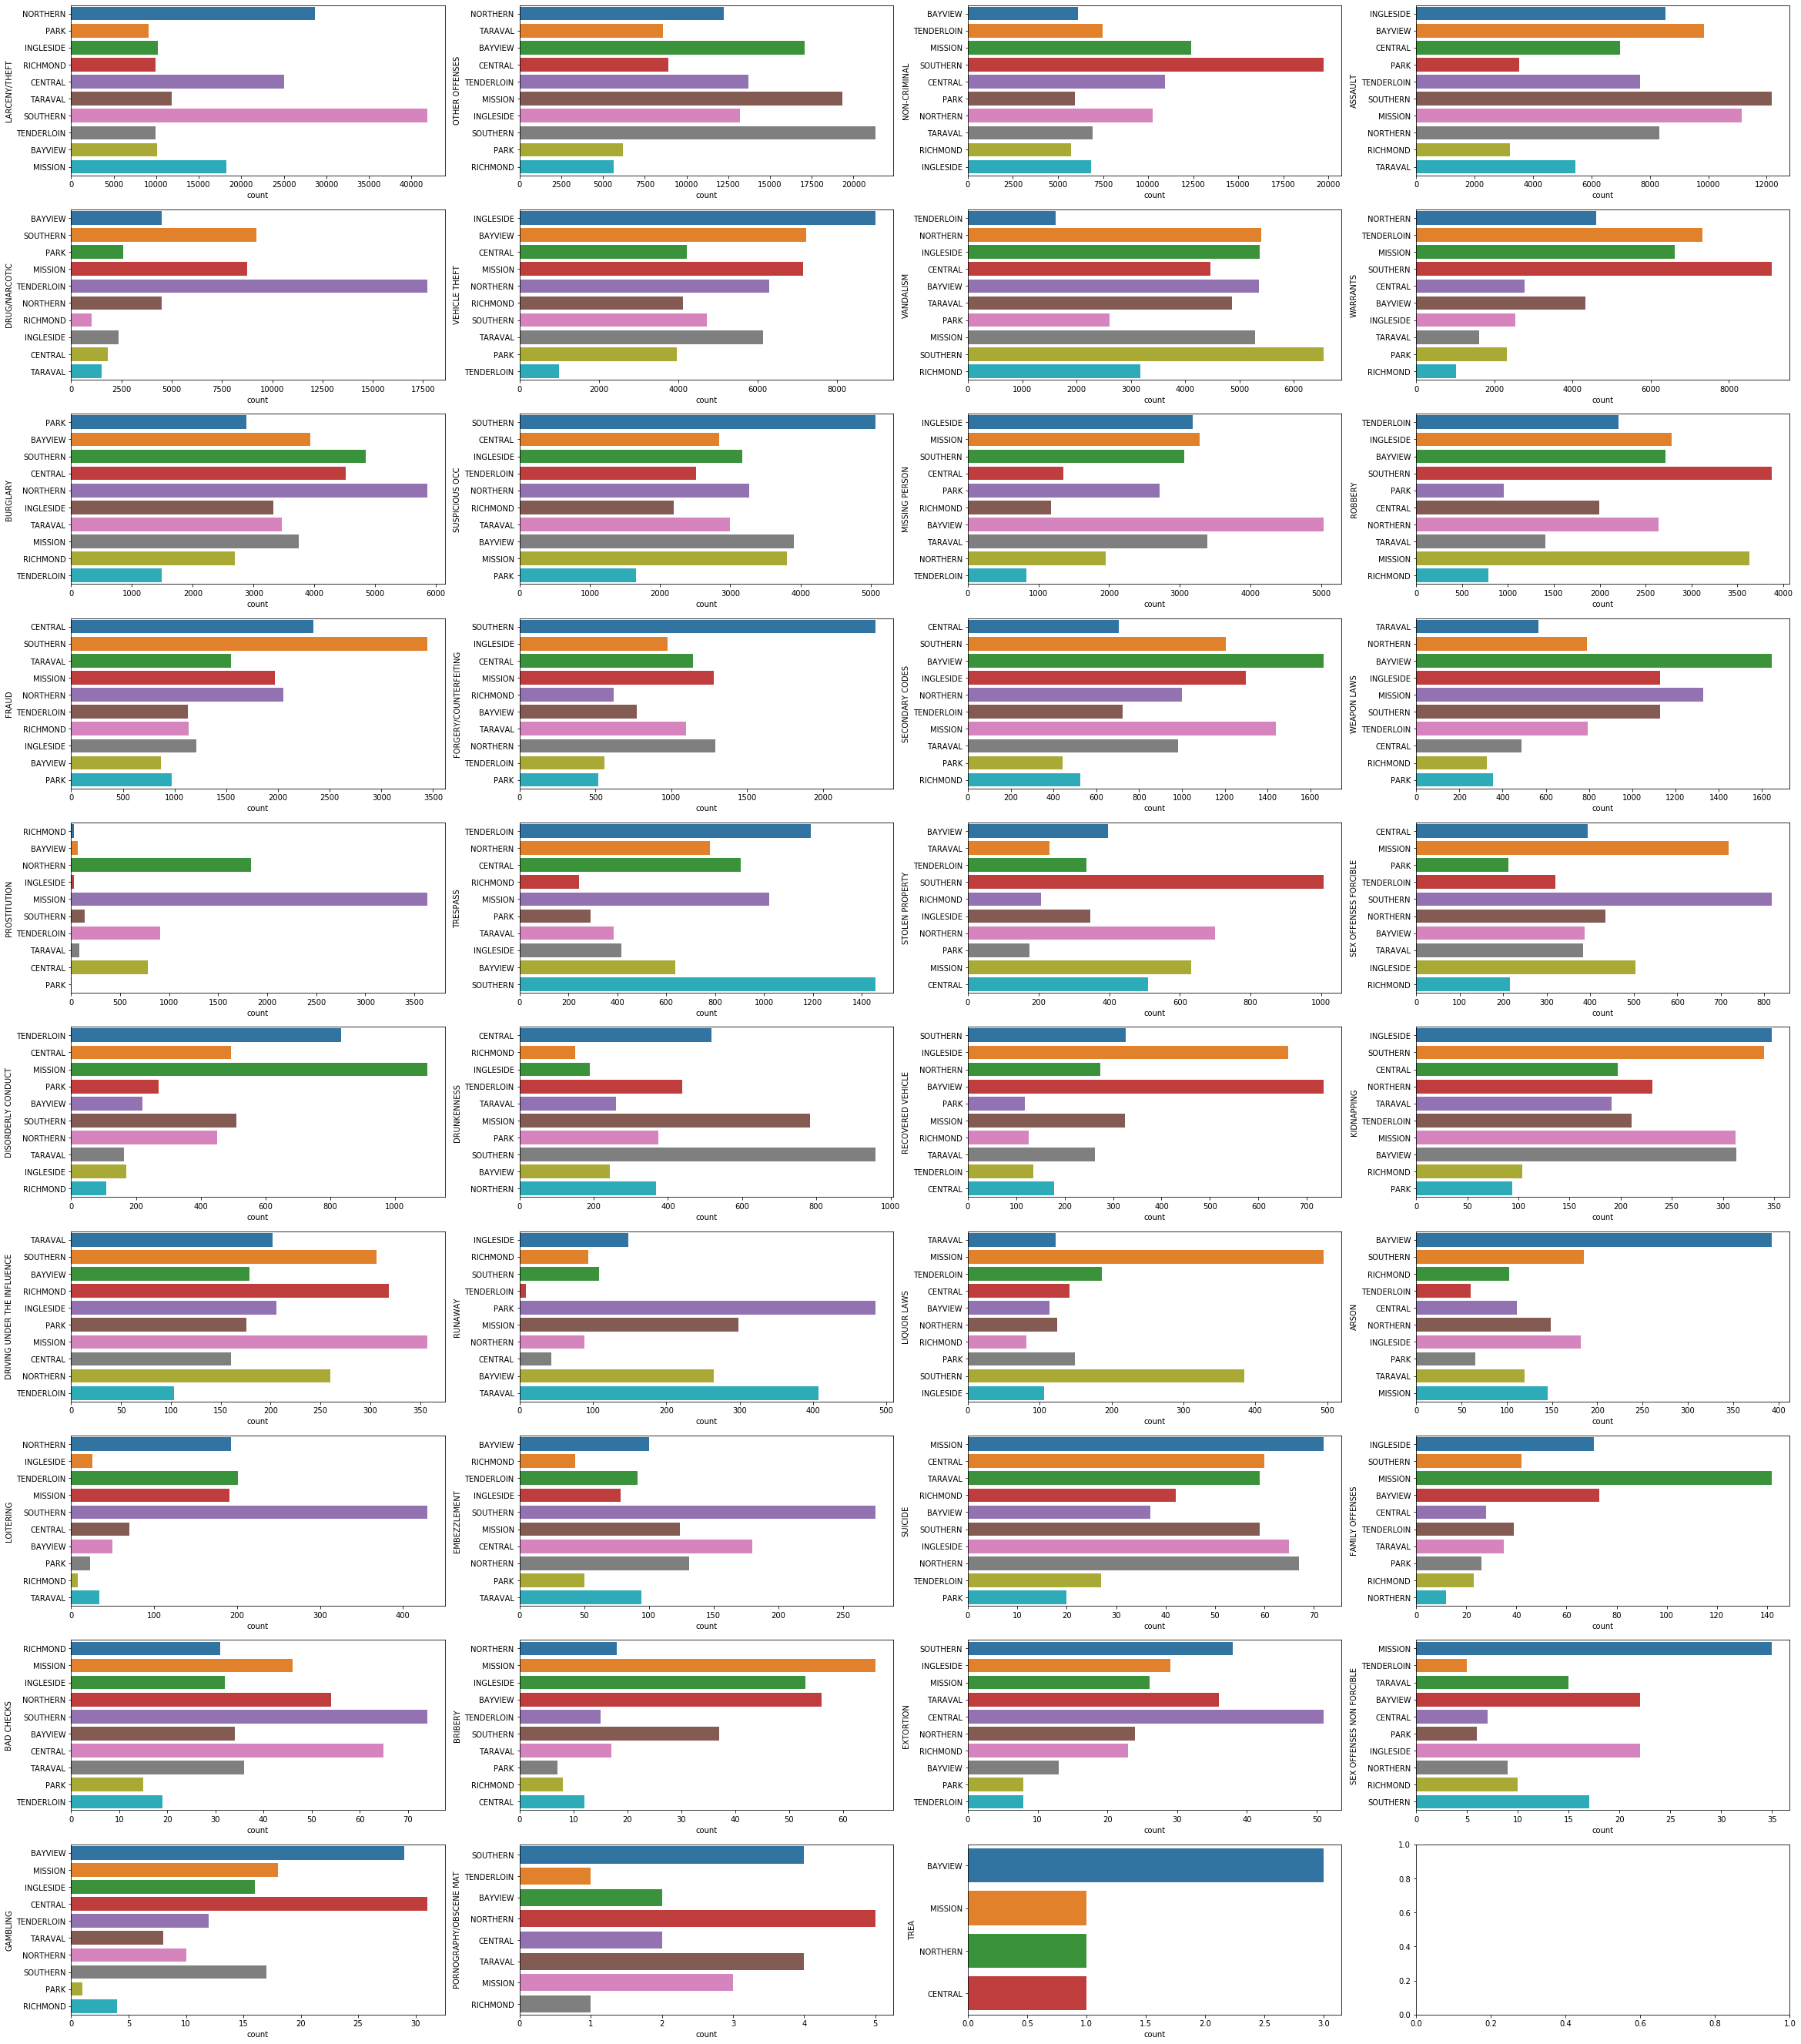

In [33]:
# 다수개의 차트를 같이 표현하는 방법
figure, axes = plt.subplots(nrows=10, ncols=4)

# 각 차트의 사이즈 지정
figure.set_size_inches(40, 48)

category_list = non_outliers["Category"].value_counts().index

# 반복문 수행
for row in range(10):
    for col in range(4):
        index = row * 4 + col #category의 개수가 39개
        
        if index < len(category_list):
            ax = axes[row][col]
            category = category_list[index]
            #print(row, col, index, category)
            
            target = non_outliers[non_outliers["Category"] == category]
            sns.countplot(y="PdDistrict", data=target, ax=ax)
            ax.set(ylabel = category)

```feadback```
1. 관할경찰서가 곧 지역을 상징하므로, 범죄가 많이 발생하는 지역에 범죄 발생빈도가 몰릴것 같다.
    - 범죄발생 빈도가 SOUTHERN은 높고, PARK와 RICHMOND는 범죄 빈도가 낮은편이다.
2. 범죄의 종류에 따라 특정 지역에서 자주 발생하는 범죄가 있을 것이다.
3. 관할경찰서가 범죄를 예측하는 모델을 개선하는데 효과가 클 것 같다.
    - PdDistrict를 one-hot encoding해서 모델에 집어 넣는다.
4. 관할경찰서라도 결국에는 지역 데이터를 상징한다. 그러므로 다른 지역데이터인 주소, 좌표와 엮어줄수 있는 방법이 있다면 모델의 성능을 개선하는데 큰 도움이 될 것 같다.

#### 2. 두번째 방법

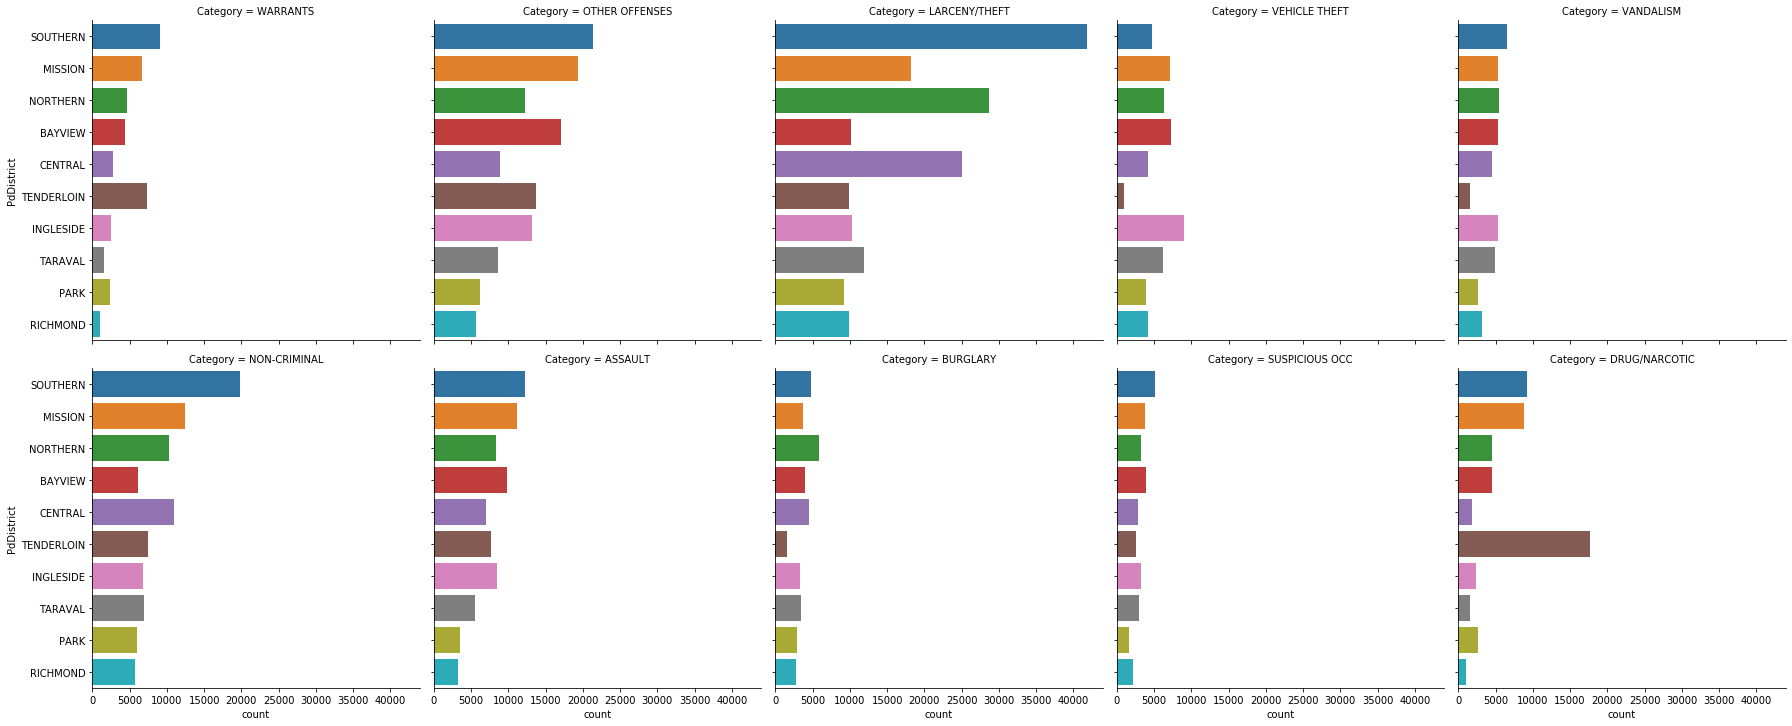

In [34]:
# 범죄 발생빈도가 높은 상위 10개 범죄 데이터
top10_category = non_outliers["Category"].value_counts().index[:10]
df_top10_category = non_outliers.loc[non_outliers["Category"].isin(top10_category)]

sns.catplot(data=df_top10_category, y="PdDistrict", 
            col="Category", col_wrap=5, kind="count",
           order=non_outliers["PdDistrict"].value_counts().index)

#### 3. 세번째 방법

In [35]:
groups2 = non_outliers.groupby(['Category', 'PdDistrict'])['PdDistrict'].count()
groups2

Category     PdDistrict
ARSON        BAYVIEW        393
             CENTRAL        111
             INGLESIDE      182
             MISSION        145
             NORTHERN       149
                           ... 
WEAPON LAWS  PARK           357
             RICHMOND       327
             SOUTHERN      1128
             TARAVAL        567
             TENDERLOIN     794
Name: PdDistrict, Length: 382, dtype: int64

In [36]:
ca_pdDistrict = groups2.unstack(fill_value=0.0)
ca_pdDistrict

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ARSON,393.0,111.0,182.0,145.0,149.0,65.0,103.0,185.0,120.0,60.0
ASSAULT,9855.0,6977.0,8532.0,11149.0,8318.0,3515.0,3202.0,12183.0,5463.0,7678.0
BAD CHECKS,34.0,65.0,32.0,46.0,54.0,15.0,31.0,74.0,36.0,19.0
BRIBERY,56.0,12.0,53.0,66.0,18.0,7.0,8.0,37.0,17.0,15.0
BURGLARY,3929.0,4519.0,3331.0,3745.0,5854.0,2888.0,2696.0,4841.0,3463.0,1488.0
DISORDERLY CONDUCT,219.0,494.0,171.0,1099.0,450.0,271.0,108.0,511.0,162.0,833.0
DRIVING UNDER THE INFLUENCE,179.0,160.0,206.0,357.0,260.0,176.0,319.0,306.0,202.0,103.0
DRUG/NARCOTIC,4498.0,1805.0,2373.0,8757.0,4511.0,2573.0,999.0,9228.0,1531.0,17696.0
DRUNKENNESS,243.0,517.0,190.0,782.0,368.0,374.0,149.0,959.0,259.0,439.0


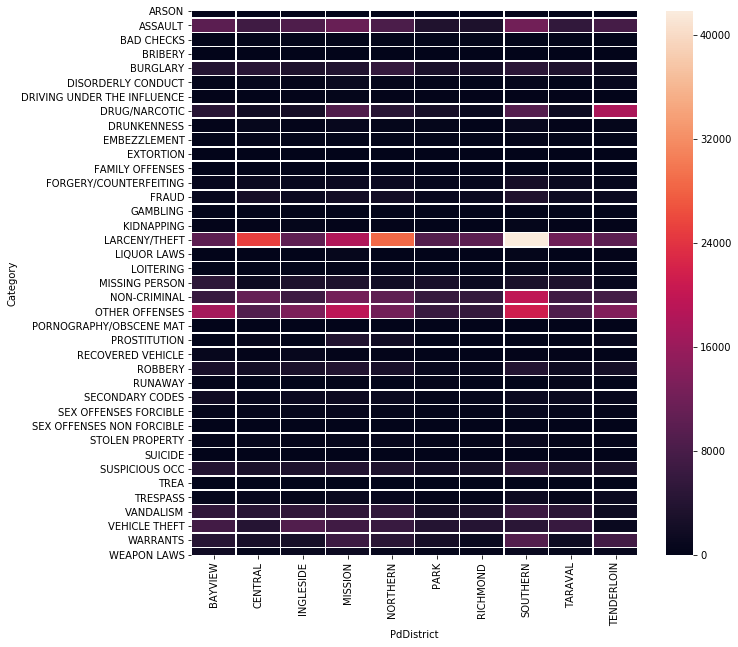

In [37]:
fg3, ax3 = plt.subplots(figsize=(10, 10))
sns.heatmap(ca_pdDistrict, linewidths=.5, ax=ax3)

In [38]:
ca_pdDistrict.loc['LARCENY/THEFT'].sort_values(ascending=False)

PdDistrict
SOUTHERN      41841.0
NORTHERN      28628.0
CENTRAL       25058.0
MISSION       18223.0
TARAVAL       11844.0
INGLESIDE     10235.0
BAYVIEW       10118.0
TENDERLOIN     9901.0
RICHMOND       9891.0
PARK           9146.0
Name: LARCENY/THEFT, dtype: float64

In [39]:
soutern = non_outliers[non_outliers["PdDistrict"] == 'SOUTHERN']
soutern.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
35,2015-05-13 20:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,SOUTHERN,NONE,KING ST / 3RD ST,-122.391846,37.778125,2015,5,13,20,30,0
40,2015-05-13 20:23:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Wednesday,SOUTHERN,NONE,700 Block of MARKET ST,-122.405295,37.786307,2015,5,13,20,23,0
41,2015-05-13 20:15:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,SOUTHERN,NONE,1600 Block of MARKET ST,-122.422128,37.773033,2015,5,13,20,15,0
52,2015-05-13 19:30:00,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Wednesday,SOUTHERN,NONE,0 Block of 3RD ST,-122.403285,37.787306,2015,5,13,19,30,0
53,2015-05-13 19:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,SOUTHERN,NONE,500 Block of BRANNAN ST,-122.397616,37.777392,2015,5,13,19,30,0


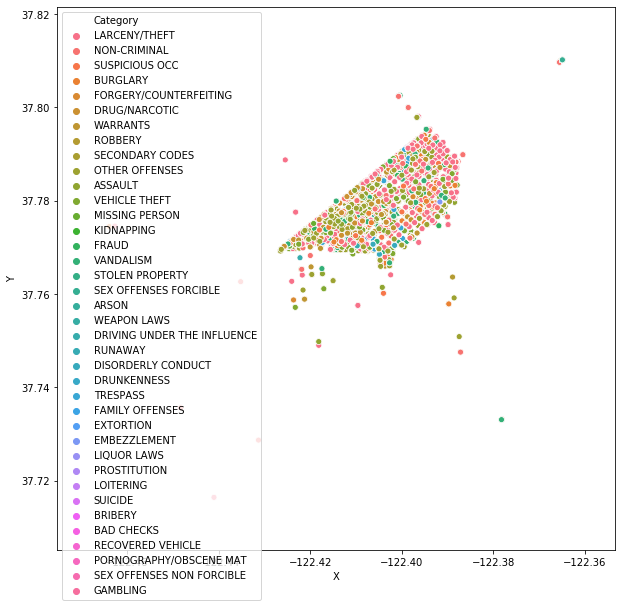

In [40]:
fg4, ax4 = plt.subplots(figsize=(10,10))
sns.scatterplot(x="X", y="Y", hue="Category", data=soutern, ax=ax4)

**참고**:  
[seaborn 시각화](https://datascienceschool.net/view-notebook/4c2d5ff1caab4b21a708cc662137bc65/)